In [1]:
#                   ----------------------  CNN version of MLP_Pytorch_NN.ipynb and NN_Pythorch.Script.py  ----------------------

import numpy as np
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import *


torch.manual_seed(777) #set the seed for reproducibility 

#############################################################################################
### Working with data
data_dict = pickle.load(open("cifar-2class-py2/cifar_2class_py2.p", "rb"), encoding="bytes")
train_data = data_dict[b'train_data']
train_labels = data_dict[b'train_labels']
test_data = data_dict[b'test_data']
test_labels = data_dict[b'test_labels']
m, n = train_data.shape # n = 32 x 32 pixels X 3 for RGB

# Create Function to create our
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

# Convert data and labels to torch tensors
train_data = torch.from_numpy(train_data).float()
train_labels = torch.from_numpy(train_labels[:, 0]).long()  # Use only the first column as labels
test_data = torch.from_numpy(test_data).float()
test_labels = torch.from_numpy(test_labels[:, 0]).long()  # Use only the first column as labels

# Create train and test datasets
train = CustomDataset(train_data, train_labels)
test = CustomDataset(test_data, test_labels)

# Create Dataloaders
batch_size = 20  # Define batch size
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test, batch_size=batch_size)

# Calculate tensor height and width
# batch = next(iter(train_dataloader))[0]
# (height, width) = batch.shape

#############################################################################################
# Define the Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=(5,5))
        self.pool1 = nn.MaxPool2d(2, 2)        
        self.conv2 = nn.Conv2d(in_channels=9, out_channels=16, kernel_size=(5,5))  # number in_chanels = previous out_channels
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(120,100),  
            nn.ReLU(),
            nn.Linear(100,2)#,
            #nn.Softmax()s
        )

    def forward(self, X):
        X = self.pool1(nn.functional.relu(self.conv1(X)))
        X = self.pool2(nn.functional.relu(self.conv2(X)))
        X = nn.functional.relu(self.conv3(X))
        X = self.flatten(X)
        logits = self.linear_relu_stack(X)
        prob = F.softmax(logits, dim=1)
        return prob

model = NeuralNetwork().to(device)
print(model)


#############################################################################################
### Param Tuning
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01 #From tensorboard we can conclude that lr=0.01 is best
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.1)# start lamb=0.01 mu=1e-4

momentum = optimizer.param_groups[0]['momentum']
weight_decay = optimizer.param_groups[0]['weight_decay']

trial_name = f"IGNORE{weight_decay}"
log_dir = f"logs/{trial_name}"
tb = SummaryWriter(log_dir=log_dir) #tensorboard


#############################################################################################
### Create Train Function
def train(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.reshape(batch_size, 3, 32, 32) #added so we can process RGB in model

        optimizer.zero_grad()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
            tb.add_scalar('Training Loss', loss_value, epoch * len(dataloader) + batch)


#############################################################################################
### Create Test function
def test(dataloader, model, epoch):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X,y) in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.reshape(batch_size, 3, 32, 32) #added so we can process RGB in model
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    tb.add_scalar('Test Accuracy', 100 * correct, epoch)


#############################################################################################
### Training and Evaluation Loop
epochs = 35
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, t)
    test(test_dataloader, model, t)
print("Done!")

tb.close()

Using cpu device
NeuralNetwork(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=120, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=2, bias=True)
  )
)
Epoch 1
-------------------------------
loss: 0.909735  [    0/10000]
loss: 0.813262  [ 2000/10000]
loss: 0.713262  [ 4000/10000]
loss: 1.013266  [ 6000/10000]
loss: 0.763252  [ 8000/10000]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.040663 

Epoch 2
-------------------------------
loss: 0.913257  [    0/10000]
loss: 0.913253  [ 2000/10000]
loss: 0.863204  [ 4000/10000]
loss: 0.963031  [ 

https://github.com/jacobgil/pytorch-grad-cam

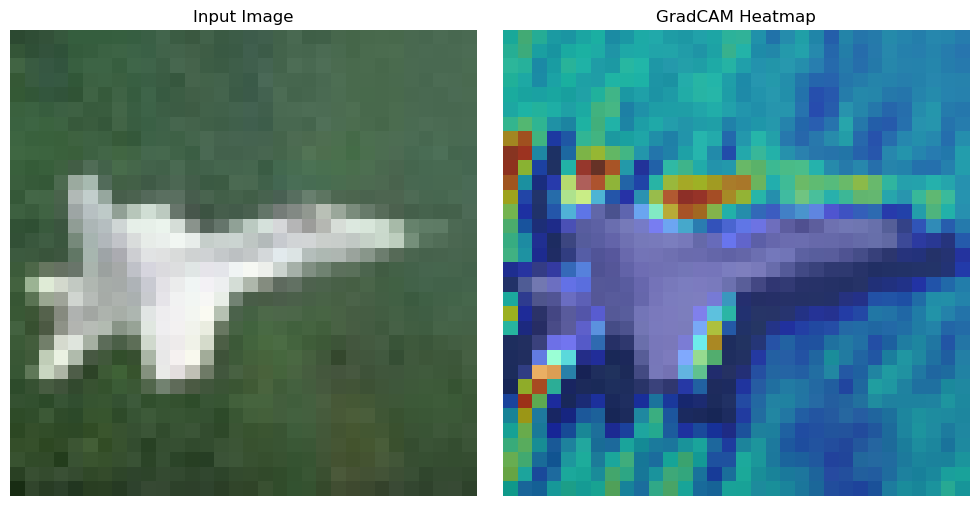

In [2]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

# Change image here
image = train_data[7]
image = image.reshape(3, 32, 32)
image = np.transpose(image.numpy(), (1, 2, 0))
image = image / 255.0

# chnage layer to look inside of here. Options are [conv1, pool1, conv2, pool2, conv3]
target_layers = [model.conv1]
input_tensor = preprocess_image(image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
cam = GradCAM(model=model, target_layers=target_layers)
targets = None
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot the input image
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Input Image')
# Plot the GradCAM heatmap on the image
axs[1].imshow(show_cam_on_image(image, grayscale_cam, use_rgb=True))
axs[1].axis('off')
axs[1].set_title('GradCAM Heatmap')
plt.tight_layout()
plt.show()
